## Calibrate cfu/mL measurement using plate reader OD600

### Experimental setup 

+ All experiments done using keio cells growing in LB (matching our data collection).
+ Measurement protocol:XX

### Measurement

Or goal is to construct a polynomial that allows us to plug in OD600 and obtain CFU/mL. To build this, we took the same samples and carefully measured both OD600 and colony forming units via serial plate dilution. 

Before fitting a model to our data, we needed to estimate uncertainties to properly weight our regression. We have two sources of experimental error in this experiment: uncertainty in our measurement of the OD600 ($\sigma_{OD600}$) and uncertainty in our measured cfu/mL $(\sigma_{cfu})$. 

We can estimate $\sigma_{OD600}$ by taking a culture and measuring its OD600 multiple times. We did ten technical replicates of this experiment for a 1:3 serial dilution covering our OD600 range of interest. (Each technical replicate involved pipetting from the cell culture tube, transfering into a 96-well plate, and then measuring the sample. This directly matches the process we used in our production experiments). The data from this experiment are in the file "20250917-serial-dilution-of-keio-cells-with-10x-technical-triplicate-od600.xlsx." We found this error was 0.9-2.0%, increasing slightly with increasing OD600. We propagated the maximum value of 2.0% through the remainder of the analysis. 

This dilution protocol also allowed us to find the detection threshold for OD600 on this plate reader: 0.096. We defined this as midway between the values of lowest two points in our dataset that differed more than this error. 

There are two sources of uncertainty in our measurement tof $(\sigma_{cfu})$. The first is counting error. We modeled this as a Poisson process: 

$$\sigma^{2}_{counts} = \frac{1}{C}$$

where $C$ is the number of colony counts. The second form of uncertainty in due do random error in our pipetting. If we have $N$ dilution steps, followed by a plating step, we have $1 + N$ events. If they are independent and share the same percent error, we get:

$$\sigma^{2}_{pipette} = (1 + N) \times (\%_{err})^2$$

Combining these, we can estimate our total variance in our estimate of CFU/mL $(\sigma^{2}_{cfu})$ as:

$$\sigma^{2}_{cfu} = \sigma^{2}_{counts} + \sigma^{2}_{pipette} = \frac{1}{C} + (1 + N) \times (\%_{err})^2$$

We independently measured cfu/mL and OD600 for 19 samples spanning OD600 0.11 to 0.59. We found the average error in CFU/mL was 10.3%. The data describing this are in "20250919_od600-vs-cfu-per-mL-by-plate-counting.xlsx". 

### Polynomial constructions

We fit a second order polynomial in OD600 to CFUl/mL. Aside from practicality, this uses the measurement with lower uncertainty (OD600) as the independent variable in regression. We regressed the polynomial coefficients with weighted nonlinear least squares, weighted by the inverse variance in each CFU/mL measurement. 

When using the polynomial to estimate cfu/mL, there are two sources of error: 

1. Uncertainty in our OD600 measurement ($\sigma_{cfu,OD600}$).
2. Uncertainty in the mapping between OD600 and cfu/mL from our fit ($\sigma_{cfu,fit}$).

The total variance is thus:

$$\sigma_{cfu}^{2}=\sigma_{OD600}^{2} + \sigma_{cfu,fit}^{2}$$

We already have an estimate of from above: $\sigma_{OD600} = 0.02$. 

The mapping error itself has two components. The first comes about because the training data did not perfectly constrain the fit parameters. We can estimate the uncertainty in our model output based on our parameter uncertainty using standard methods from non-linear regression:  

$$\sigma_{cfu,fit}^{2} \approx\boldsymbol{J}_{p}\boldsymbol{C}_{p}\boldsymbol{J}_{p}^{T}$$

where $\boldsymbol{J}_{p}$ is the Jacobian (numerically approximated during the regression) and $\boldsymbol{C}_{p}$ contains the values of OD600 at which we estimate cfu/mL. 

The second mapping error comes about beceause the curve is nonlinear. This means the propagation of $\sigma_{OD600}$ through the curve is not constant: the steeper the curve, the higher our output uncertainty. We can describe this dependence by:

$$\sigma^{2}_{OD600,propagated} = \sigma_{OD600}^{2}\left(\frac{\partial [cfu/mL]}{\partial [OD600]}\right)^{2}$$

Because we fit a polynomial of the form $cfu/mL \sim a + b\times OD600 + c\times (OD600)^2$, the partial derivative is $b + 2c\times OD600$. The total uncertainty in our estimated CFU/mL given a measurement of $OD_{600}$ is thus:

$$\sigma_{cfu} = \sqrt{\boldsymbol{J}_{p}\boldsymbol{C}_{p}\boldsymbol{J}_{p}^{T}+(0.02 \times OD600)^{2} \times \left (b + 2c\times OD600 \right)^2}$$

To make this analysis practical, we calculated $\boldsymbol{J}_{p}\boldsymbol{C}_{p}\boldsymbol{J}_{p}^{T}$ as a function of OD600, then fit another second order polynomial (with coefficients $p$, $q$, and $r$) to this curve. This allows us to rapidly calculate $\boldsymbol{J}_{p}\boldsymbol{C}_{p}\boldsymbol{J}_{p}^{T}$ for any value of $OD600$. 

### Final models

Our final protocol allows us to estimate cfu/mL and $\sigma_{cfu}$ with the following:

$$cfu/mL \sim a + b\times OD600 + c^{2} \times OD600$$
$$\sigma_{cfu} \sim \sqrt{(p + q\times OD600 + r\times(OD600)^2)+(0.02 \times OD600)^{2} \times \left (b + 2c\times OD600 \right)^2}$$

where $a = -5388603.36438282$, $b = 66683325.953339$, $c = 38292706.79524336$, $p = 801108.73371897$, $q = -5133635.54769162$, and $r = 13418613.55590658$. 

If $OD600 < 0.096$ it is below our detection limit. 




In [51]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from tfscreen.fitting import (
    run_least_squares,
    predict_with_error
)

SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


def simple_poly(params: np.ndarray, x: np.ndarray) -> np.ndarray:
    """
    Evaluate a polynomial at specific x values.

    The polynomial is defined by the coefficients in `params`. The function
    assumes the coefficients are ordered from the lowest degree to the highest
    (c_0, c_1, c_2, ...).

    Parameters
    ----------
    params : numpy.ndarray
        An array of polynomial coefficients in order `[c0, c1, c2, ...]`.
        Shape should be 1D. 
    x : numpy.ndarray
        A 1D array of the points at which to evaluate the polynomial(s),
        with shape (N,).

    Returns
    -------
    numpy.ndarray
        A 1D array containing the result of the polynomial evaluation(s).
    """
    
    # Create an exponent for each coefficient row: [0, 1, 2, ...]'
    exponents = np.arange(params.shape[0])
    terms = params[:, np.newaxis] * (x ** exponents[:, np.newaxis])
    
    return np.sum(terms, axis=0)



### OD600 measurment

We need to figure out two things about the OD600 measurement itself. First, what is the detection threshold? Second, what is the spread on replicate measurements? In this, we are going to assume that we remain well below the upper limit of detection. 

In [52]:
# Read in the dataframe with replicate OD600 measurements

df = pd.read_excel("20250917-serial-dilution-of-keio-cells-with-10x-technical-triplicate-od600.xlsx",
              sheet_name="1-3dilution",
              header=None,
              names=[f"rep{i}" for i in range(10)])
df["dilution"] = 1/(3**(np.arange(len(df))))
df = df.set_index("dilution")
df

,rep0,rep1,rep2,rep3,rep4,rep5,rep6,rep7,rep8,rep9
dilution,,,,,,,,,,
1.000000,0.5993,0.6060,0.5971,0.5928,0.5954,0.5929,0.5895,0.5906,0.5996,0.5868
0.333333,0.2733,0.2721,0.2705,0.2671,0.2670,0.2660,0.2673,0.2661,0.2655,0.2590
0.111111,0.1505,0.1503,0.1483,0.1471,0.1461,0.1429,0.1430,0.1434,0.1442,0.1431
0.037037,0.1090,0.1113,0.1085,0.1094,0.1111,0.1076,0.1081,0.1106,0.1096,0.1100
0.012346,0.0983,0.0989,0.0969,0.0972,0.0994,0.0960,0.0966,0.0979,0.1003,0.1003
0.004115,0.0949,0.0934,0.0938,0.0933,0.0932,0.0929,0.0927,0.0928,0.0930,0.0928


### Identify detection threshold

Detection threshold is: 0.09573000000000001


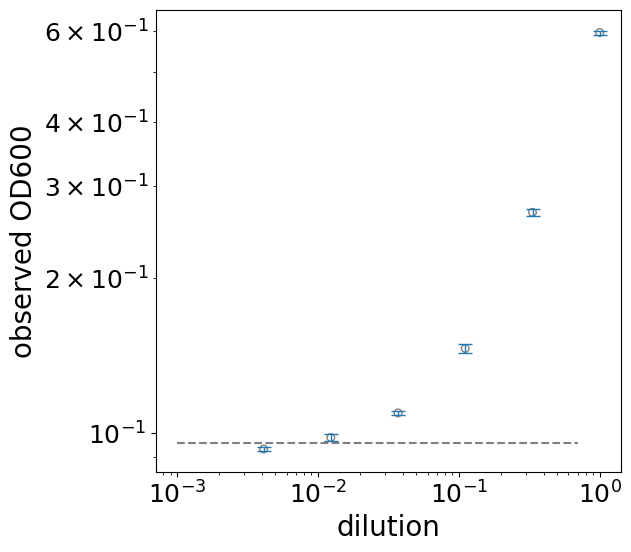

In [53]:
# Get mean and standard deviation from the rows

arr = df.to_numpy()
mu = np.mean(arr,axis=1)
std = np.std(arr,axis=1)

fig, ax = plt.subplots(1,figsize=(6,6))

ax.errorbar(x=df.index,
            y=mu,
            yerr=std,
            elinewidth=1,capsize=5,lw=0)
ax.scatter(x=df.index,
           y=mu,
           s=30,edgecolor="gray",facecolor="none")

od600_meas_threshold = (mu[-2] - mu[-1])/2 + mu[-1]
ax.plot([0.001,0.7],[od600_meas_threshold,od600_meas_threshold],'--',color='gray')
ax.set_xlabel("dilution")
ax.set_ylabel("observed OD600")

ax.set_yscale('log')
ax.set_xscale('log')

# Detection limit is midway between lowest and next-to-lowest point
print(f"Detection threshold is: {od600_meas_threshold}")


### Characterize how the OD600 measurement uncertainty varies with OD600 value

OD600 meas error vs. log(OD600) intercept: 0.0068743731997848775
OD600 meas error vs. log(OD600) slope: 0.0024295904612180188
OD600 average % error: 1.2540323503653896
OD600 max % error: 1.964606679505892


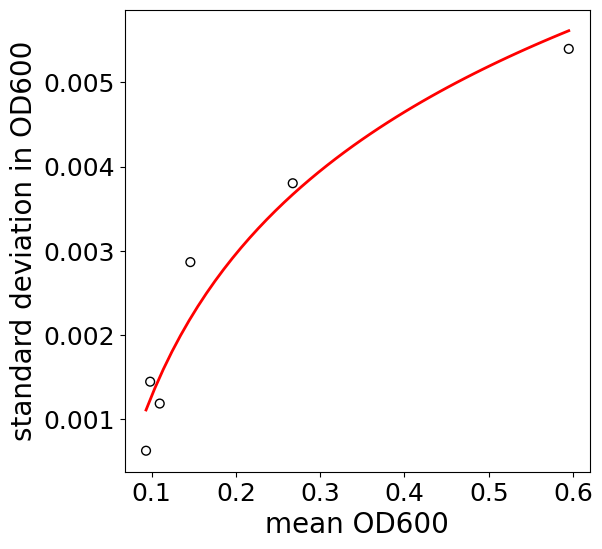

In [54]:
# Error in OD600 is linear in log(OD600). 
fig, ax = plt.subplots(1,figsize=(6,6))

# Fit a line to OD600 measurement uncertainty vs. log(OD600)
p = np.polynomial.Polynomial.fit(np.log(mu),std,deg=1,domain=[])
mu_smooth = np.linspace(np.min(mu),np.max(mu))

# Plot 
ax.scatter(mu,std,s=40,edgecolor="black",facecolor="none")
ax.plot(mu_smooth,p(np.log(mu_smooth)),lw=2,color='red')
ax.set_xlabel("mean OD600")
ax.set_ylabel("standard deviation in OD600")

od600_std_b, od600_std_m = p.coef

print(f"OD600 meas error vs. log(OD600) intercept: {od600_std_b}")
print(f"OD600 meas error vs. log(OD600) slope: {od600_std_m}")
print(f"OD600 average % error: {np.mean(std/mu)*100}")
print(f"OD600 max % error: {np.max(std/mu)*100}") # <- use this maximum value of 0.02 throughout the analysis

### Analyze counts data to extract cfu and cfu error

In [55]:
pc_df = pd.read_excel("20250919_od600-vs-cfu-per-mL-by-plate-counting.xlsx")
pc_df

,Plate Number,CFU,Volume_mL,Dilution,CFU_per_mL,OD600 plate reader,replicate,num_dilutions,plating_steps
0,5,485,0.1,100000,485000000,0.5880,20250213,5,1
1,6,385,0.1,100000,385000000,0.5299,20250213,5,1
2,7,315,0.1,100000,315000000,0.4499,20250213,5,1
3,8,244,0.1,100000,244000000,0.3857,20250213,5,1
4,9,198,0.1,100000,198000000,0.3386,20250213,5,1
5,10,161,0.1,100000,161000000,0.2941,20250213,5,1
6,11,146,0.1,100000,146000000,0.2588,20250213,5,1
7,12,101,0.1,100000,101000000,0.2267,20250213,5,1
8,13,75,0.1,100000,75000000,0.1830,20250213,5,1
9,14,68,0.1,100000,68000000,0.1680,20250213,5,1


### Extract estimate of cfu and cfu_std based on counting statistics and pietting error

In [56]:
pipette_pct_err = 0.02

# cfu
cfu = pc_df["CFU"].to_numpy()*pc_df["Dilution"]

# cfu std
sigma2_counts = 1/pc_df["CFU"]
sigma2_dilution = (pc_df["num_dilutions"] + pc_df["plating_steps"])*(pipette_pct_err**2)
cfu_std = cfu*np.sqrt(sigma2_counts + sigma2_dilution)

# od66 
pc_df["od600"] = pc_df["OD600 plate reader"].to_numpy()
pc_df["od600_std"] = 0.02*(pc_df["od600"])
pc_df["cfu_per_mL"] = cfu
pc_df["cfu_per_mL_std"] = cfu_std

print(f"cfu/mL percent error: {np.mean(pc_df['cfu_per_mL_std']/pc_df['cfu_per_mL'])*100}")


cfu/mL percent error: 10.31279987848501


### Fit a polynomial to cfu/mL vs. OD600

In [57]:
# Get polynomial relating od600_est to cfu_est and cfu_std
params, param_std, cov_matrix, fit = run_least_squares(simple_poly,
                                                       pc_df["cfu_per_mL"].to_numpy(),
                                                       pc_df["cfu_per_mL_std"].to_numpy(),
                                                       [1,0,0],
                                                       args=(pc_df["od600"].to_numpy(),))
print("cfu/mL vs od600 parameters")
print(params)

cfu/mL vs od600 parameters
[-5388603.36438282 66683325.953339   38292706.79524336]


/Users/harmsm/miniconda3/lib/python3.12/site-packages/numpy/_core/numeric.py:476: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(res, fill_value, casting='unsafe')


### Fit a polynomial of cfu/mL error to OD600. 

In [58]:

# Using covariance matrix, estimate cfu_pred_std --> the standard error on
# our predicted cfu/mL given the model
od600_smooth = np.linspace(np.min(pc_df["od600"])*0.95,np.max(pc_df["od600"])*1.05,20)
cfu_pred, cfu_pred_std = predict_with_error(simple_poly,
                                            params,
                                            cov_matrix,
                                            args=(od600_smooth,))

# Create a polynomial of cfu_pred_std vs. od600, allowing us to calculate 
# our cfu_pred_std given od600. 
err_params, _, err_cov_matrix, _ = run_least_squares(simple_poly,
                                                           cfu_pred_std,
                                                           np.full(len(cfu_pred),0.1e7),
                                                           [1,0,0],
                                                           args=(od600_smooth,))

print("JCpJ^T approximation parameters")
print(err_params)

JCpJ^T approximation parameters
[  801108.73371897 -5133635.54769162 13418613.55590658]


### Final synthesized function

In [59]:
import numpy as np

def od600_to_cfu(od600):
    """
    Convert Harms lab plate reader OD600 values to cfu/mL using empirical
    calibration parameters. 
    
    This is **only** valid when measuring samples of XX uL in luria broth
    in clear-bottom 96 well plates on the SpectraMaxI3. Upper bound for 
    reliable measurements is an OD600 of 0.600. The lower detection threshold 
    is 0.096. Calibration done 2025/09/19. 

    Parameters
    ----------
    od600 : np.ndarray
        array of OD600 measurements

    Returns
    -------
    cfu_est : np.ndarray
        1D array of estimated cfu/mL from OD600
    cfu_std : np.ndarray
        1D array of standard error on the estimated cfu/mL
    detectable : np.ndarray
        1D boolean array indicating whether the OD600 was above the 
        detection threshold. (True means measurable; False means too low to see). 
    """

    # emprically, od600 measurement threshold
    od600_meas_threshold = 0.09573000000000001

    # emprical od600 to cfu, 2nd-order polynomial
    a_cfu = -5388603.36438282 
    b_cfu = 66683325.953339 
    c_cfu = 38292706.79524336 

    # empirical cfu standard error vs. od600, 2nd-order polynomial
    # This approximates J @ P @ J^T.
    p_jcjt = 801108.73371897 
    q_jcjt = -5133635.54769162 
    r_jcjt = 13418613.55590658 

    # pct error in od600 measurements
    od600_pct_std = 0.02

    # see if we are dealing with a single value. Turn into an array for
    # simplicity. 
    single_value = False
    if np.isscalar(od600):
        single_value = True
        od600 = np.array([od600])
    
    # work on a copy
    od600 = od600.copy()
    
    # left-cap values below the measurement threshold
    detectable = np.ones(len(od600),dtype=bool)
    detectable[od600 < od600_meas_threshold] = False
    od600[od600 < od600_meas_threshold] = od600_meas_threshold
        
    # caclulate cfu estimate
    cfu_est = a_cfu + b_cfu*(od600) + c_cfu*(od600**2)
    
    # caclulate J @ Cp @ J^T 
    cfu_est_std_2 = (p_jcjt + q_jcjt*(od600) + r_jcjt*(od600**2))**2
    
    # caclulate (dy/dx)^2 of the cfu vs od600 curve
    dy_dx_2 = (b_cfu + 2*c_cfu*od600)**2
    
    # caclulate (error in od600 measurement)^2
    od600_std_2 = (od600_pct_std*od600)**2 
    
    # Final cfu_err is square root of combined variances
    cfu_std = np.sqrt(cfu_est_std_2 + dy_dx_2*od600_std_2)
    
    if single_value:
        cfu_est = cfu_est[0]
        cfu_std = cfu_std[0]
        detectable = detectable[0]
    
    return cfu_est, cfu_std, detectable


### Create a plot of results

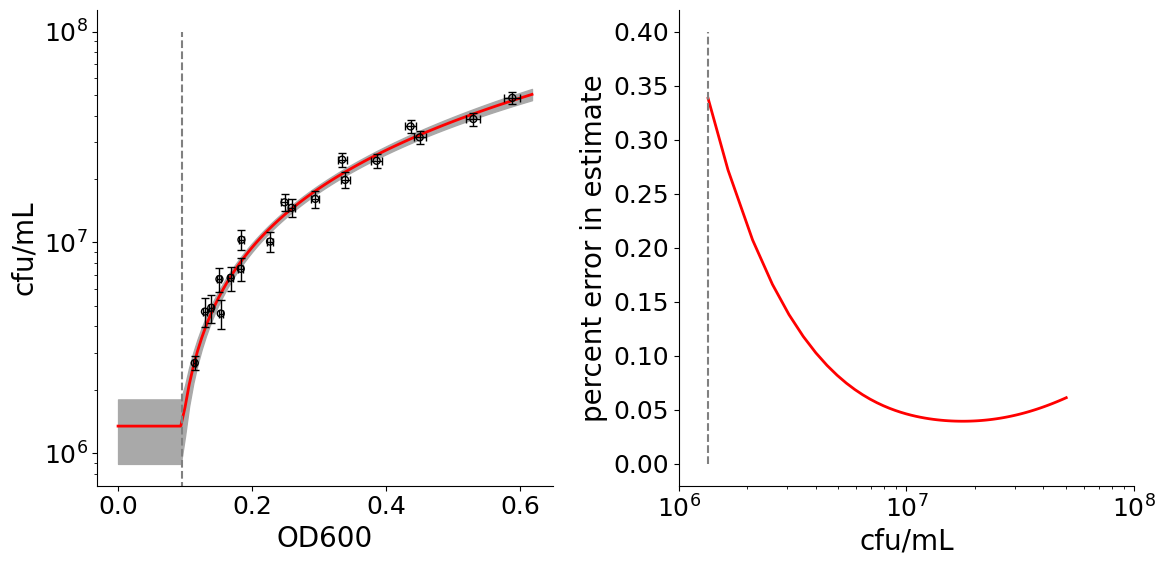

In [61]:
od600_smooth = np.linspace(0,np.max(pc_df["od600"])*1.05,100)
cfu_est_final, cfu_std_final, detectable = od600_to_cfu(od600_smooth)

fig, ax = plt.subplots(1,2,figsize=(12,6))
ax[0].scatter(pc_df["od600"], 
           pc_df["cfu_per_mL"], 
           s=25,facecolor='none',edgecolor='black',zorder=10)
ax[0].errorbar(x=pc_df["od600"], 
            xerr=pc_df["od600_std"],
            y=pc_df["cfu_per_mL"],
            yerr=pc_df["cfu_per_mL_std"],
            lw=0,capsize=3,color='black',elinewidth=1,zorder=10)

ax[0].plot(od600_smooth,cfu_est_final,'-',color='red',lw=2)
ax[0].fill_between(od600_smooth,
                cfu_est_final-cfu_std_final,
                cfu_est_final+cfu_std_final,
                color='darkgray',
                zorder=-3)
ax[0].plot([od600_meas_threshold,od600_meas_threshold],
        [0,1e8],'--',color='gray')

ax[0].set_xlabel("OD600")
ax[0].set_ylabel("cfu/mL")
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].set_yscale("log")


min_detectable, _, _ = od600_to_cfu(0.09573000000000001)
ax[1].plot(cfu_est_final,cfu_std_final/cfu_est_final,lw=2,color='red')
ax[1].plot([min_detectable,min_detectable],[0,0.4],'--',color='gray')


ax[1].set_xlabel("cfu/mL")
ax[1].set_ylabel("percent error in estimate")
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].set_xlim(1e6,1e8)
ax[1].set_xscale('log')

fig.tight_layout()
fig.savefig("calibration-results.png",transparent=True)
